# Comparing Optimizations between gp_minimize and the Optimizer class

I wanted to look a bit more closely at how gp_minimize and the Optimizer class compare. Nearly all of this code follows from Scikit-Optimize's demonstrations [1] and [2].

#### References
[1] https://scikit-optimize.github.io/notebooks/bayesian-optimization.html
<br>
[2] https://scikit-optimize.github.io/notebooks/parallel-optimization.html

In [71]:
import numpy as np
np.random.seed(123)

import skopt

%matplotlib inline
import matplotlib.pyplot as plt

### Defining our function

In [2]:
noise_level = 0.1

def f(x, noise_level=noise_level):
    return np.sin(5 * x[0]) * (1 - np.tanh(x[0] ** 2)) + np.random.randn() * noise_level

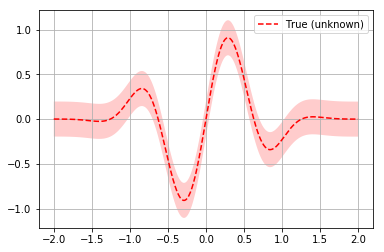

In [3]:
# Plot f(x) + contours
x = np.linspace(-2, 2, 400).reshape(-1, 1)
fx = [f(x_i, noise_level=0.0) for x_i in x]
plt.plot(x, fx, "r--", label="True (unknown)")
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate(([fx_i - 1.9600 * noise_level for fx_i in fx], 
                         [fx_i + 1.9600 * noise_level for fx_i in fx[::-1]])),
         alpha=.2, fc="r", ec="None")
plt.legend()
plt.grid()
plt.show()

## Starting with gp_minimize

In [65]:
# Explicitly set these dimensions
dimensions = [(-2.0, 2.0)]

In [66]:
from skopt import gp_minimize

res = gp_minimize(f,                        # the function to minimize
                  dimensions=dimensions,    # the bounds on each dimension of x
                  acq_func="EI",            # the acquisition function
                  n_calls=30,               # the number of evaluations of f 
                  n_random_starts=10,       # the number of random initialization points
                  #noise=0.1**2,            # the noise level (optional)
                  random_state=123)         # the random seed

In [67]:
res.fun

-1.0928255244927803

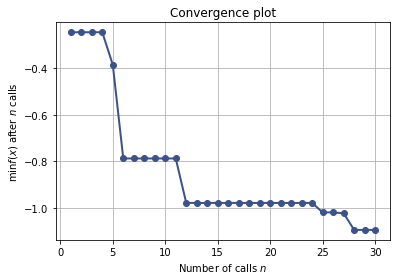

In [68]:
from skopt.plots import plot_convergence
plot_convergence(res);

## Moving to Optimizer

#### Dimension Transformations to Match the Optimizer with gp_minimize

The following function lifts to extra dimension transformations from gp_minimize to be used by the Optimizer. Since our dimension in this case is (-2.0, 2.0), we should normalize those to be between 0 and 1. 

In [78]:
 from skopt.space import check_dimension, Categorical

def transform_gpdims(dimensions):
    """
    Transforms space for Gaussian processes.

    Parameters
    ----------
    * `dimensions` [list, shape=(n_dims,)]:
        List of search space dimensions.
        Each search dimension can be defined either as

        - a `(upper_bound, lower_bound)` tuple (for `Real` or `Integer`
          dimensions),
        - a `(upper_bound, lower_bound, "prior")` tuple (for `Real`
          dimensions),
        - as a list of categories (for `Categorical` dimensions), or
        - an instance of a `Dimension` object (`Real`, `Integer` or
          `Categorical`).

         NOTE: The upper and lower bounds are inclusive for `Integer`
         dimensions.
    """
    dim_types = [check_dimension(d) for d in dimensions]
    is_cat = all([isinstance(check_dimension(d), Categorical)
                  for d in dim_types])
    if is_cat:
        transformed_dims = [check_dimension(d, transform="identity")
                            for d in dimensions]
    else:
        transformed_dims = []
        for dim_type, dim in zip(dim_types, dimensions):
            if isinstance(dim_type, Categorical):
                transformed_dims.append(
                    check_dimension(dim, transform="onehot")
                    )
            # To make sure that GP operates in the [0, 1] space
            else:
                transformed_dims.append(
                    check_dimension(dim, transform="normalize")
                    )
    return transformed_dims

In [91]:
transformed_dims = transform_gpdims(dimensions)

# Does this actually transform the dimension?
print(transformed_dims)

[Real(low=-2.0, high=2.0, prior=uniform, transform=normalize)]


In [81]:
from skopt import Optimizer
#from skopt.learning import GaussianProcessRegressor

optimizer = Optimizer(
    base_estimator="GP",
    acq_func="EI",
    acq_optimizer="lbfgs",
    dimensions=transformed_dims,
    random_state=123
)

x_vals = []
y_vals = []
tell_vals = []
for i in range(30): 
    x = optimizer.ask(n_points=1)  # x is a list of n_points points   
    x_vals.append(x)
    y = f(x[0])  # evaluate points in parallel
    y_vals.append(y)
    optimizer.tell(x[0], y)

# takes ~ 20 sec to get here
print(min(optimizer.yi))  # print the best objective found 

-1.01649221064


In [82]:
opti = optimizer.run(f)

In [83]:
# Naive comparison
opti.fun == min(optimizer.yi)

True

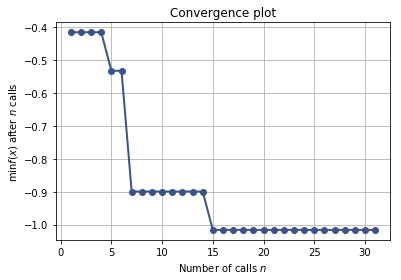

In [84]:
plot_convergence(opti);

## Taking a Look at gp_minimize

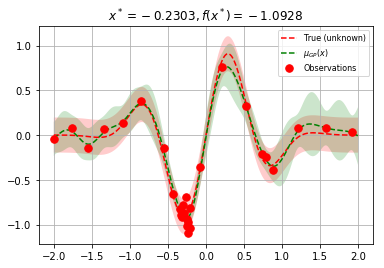

In [85]:
plt.rcParams["figure.figsize"] = (6, 4)

# Plot f(x) + contours
x = np.linspace(-2, 2, 400).reshape(-1, 1)
x_gp = res.space.transform(x.tolist())

fx = [f(x_i, noise_level=0.0) for x_i in x]
plt.plot(x, fx, "r--", label="True (unknown)")
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate(([fx_i - 1.9600 * noise_level for fx_i in fx], 
                         [fx_i + 1.9600 * noise_level for fx_i in fx[::-1]])),
         alpha=.2, fc="r", ec="None")

# Plot GP(x) + contours
gp = res.models[-1]
y_pred, sigma = gp.predict(x_gp, return_std=True)

plt.plot(x, y_pred, "g--", label=r"$\mu_{GP}(x)$")
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma, 
                         (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.2, fc="g", ec="None")

# Plot sampled points
plt.plot(res.x_iters, 
         res.func_vals, 
         "r.", markersize=15, label="Observations")

plt.title(r"$x^* = %.4f, f(x^*) = %.4f$" % (res.x[0], res.fun))
plt.legend(loc="best", prop={'size': 8}, numpoints=1)
plt.grid()

plt.show()

## A look into Optimizer

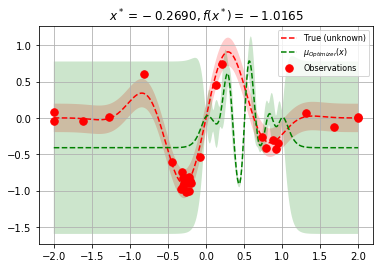

In [86]:
plt.rcParams["figure.figsize"] = (6, 4)

# Plot f(x) + contours
x = np.linspace(-2, 2, 400).reshape(-1, 1)
x_gp = res.space.transform(x.tolist())

fx = [f(x_i, noise_level=0.0) for x_i in x]
plt.plot(x, fx, "r--", label="True (unknown)")
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate(([fx_i - 1.9600 * noise_level for fx_i in fx], 
                         [fx_i + 1.9600 * noise_level for fx_i in fx[::-1]])),
         alpha=.2, fc="r", ec="None")

# Plot GP(x) + contours
gp = opti.models[-1]
y_pred, sigma = gp.predict(x_gp, return_std=True)

plt.plot(x, y_pred, "g--", label=r"$\mu_{Optimizer}(x)$")
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma, 
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.2, fc="g", ec="None")

# Plot sampled points
plt.plot(opti.x_iters, 
         opti.func_vals, 
         "r.", markersize=15, label="Observations")

plt.title(r"$x^* = %.4f, f(x^*) = %.4f$" % (opti.x[0], opti.fun))
plt.legend(loc="best", prop={'size': 8}, numpoints=1)
plt.grid()

plt.show()

### Notes

It is a bit confusing what is going on here. When using Optimizer, we get similar observations to gp_minimize, but the the $\mu_{Optimizer}(x)$ seems to be quite off. 